In [1]:
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import random

from IPython.core.display import HTML


Using TensorFlow backend.


**
1.
A. Download the Celeb A dataset ZIP, and the images in "img_align_celeba" are the dataset. Use a Keras Custom Data Generator. Then load attribute data in the file "list_attr_celeba.csv" into  a pandas dataframe. **

In [30]:
#remove any existent file
!rm -rf vae
!rm celebB.hdf5

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rm: celebB.hdf5: No such file or directory


In [31]:
#clone the project here
!git clone https://github.com/rahul2240/vae-dcgan-celeb
    
#rename it to vae
!mv ./vae-dcgan-celeb ./vae

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'vae-dcgan-celeb': No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
mv: rename ./vae-dcgan-celeb to ./vae: No such file or directory


In [2]:
#Download dataset

!wget https://www.dropbox.com/s/myx5glxrae71dsu/celeba-dataset.zip?dl=0


--2019-04-24 14:05:23--  https://www.dropbox.com/s/myx5glxrae71dsu/celeba-dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6019:1::a27d:401, 162.125.4.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6019:1::a27d:401|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/myx5glxrae71dsu/celeba-dataset.zip [following]
--2019-04-24 14:05:23--  https://www.dropbox.com/s/raw/myx5glxrae71dsu/celeba-dataset.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca7234b5a213b939a9ffad0ef1f.dl.dropboxusercontent.com/cd/0/inline/Afo3juNTmilE6G6Z4QhcCAjEsA85Jxb-6cmRmCNoMp39Nm6EB153Y1ZzFHBiXVtnw0JcvRWgRpNPFA3-gQaGvVydKAH0g5iAkpCSCFWVyYXonQ/file# [following]
--2019-04-24 14:05:24--  https://uca7234b5a213b939a9ffad0ef1f.dl.dropboxusercontent.com/cd/0/inline/Afo3juNTmilE6G6Z4QhcCAjEsA85Jxb-6cmRmCNoMp39Nm6EB153Y1ZzFHBiXVtnw0JcvRWgRpNPFA3-gQaGvVydKAH0g5iA

In [3]:
!mv celeba-dataset.zip\?dl\=0 img_align.zip

In [4]:
! unzip img_align.zip

Archive:  img_align.zip
  inflating: list_attr_celeba.csv    
  inflating: img_align_celeba.zip    
  inflating: list_landmarks_align_celeba.csv  
  inflating: list_bbox_celeba.csv    
  inflating: list_eval_partition.csv  


In [0]:
! unzip img_align_celeba.zip

Archive:  img_align_celeba.zip
   creating: img_align_celeba/
 extracting: img_align_celeba/000001.jpg  
 extracting: img_align_celeba/000002.jpg  
 extracting: img_align_celeba/000003.jpg  
 extracting: img_align_celeba/000004.jpg  
 extracting: img_align_celeba/000005.jpg  
 extracting: img_align_celeba/000006.jpg  
 extracting: img_align_celeba/000007.jpg  
 extracting: img_align_celeba/000008.jpg  
 extracting: img_align_celeba/000009.jpg  
 extracting: img_align_celeba/000010.jpg  
 extracting: img_align_celeba/000011.jpg  
 extracting: img_align_celeba/000012.jpg  
 extracting: img_align_celeba/000013.jpg  
 extracting: img_align_celeba/000014.jpg  
 extracting: img_align_celeba/000015.jpg  
 extracting: img_align_celeba/000016.jpg  
 extracting: img_align_celeba/000017.jpg  
 extracting: img_align_celeba/000018.jpg  
 extracting: img_align_celeba/000019.jpg  
 extracting: img_align_celeba/000020.jpg  
 extracting: img_align_celeba/000021.jpg  
 extracting: img_align_celeba/00002

In [8]:
# run collab.py if the dataset is present in ./img_align_celeba otherwise change the directory inside it
!python vae/datasets/collab.py

Downloading: https://drive.google.com/open?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
26.72 MB downloaded...
Finish!
202599 images
tcmalloc: large alloc 2489540608 bytes == 0x3534000 @  0x7f1d948e91e7 0x7f1d91e16e51 0x7f1d91e7b8d8 0x7f1d91e1a651 0x5553b5 0x5a730c 0x503073 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x506393 0x634d52 0x634e0a 0x6385c8 0x63915a 0x4a6f10 0x7f1d944e6b97 0x5afa0a


In [27]:
# remove any existent folder nad create a new one for result
!rm -rf output
!mkdir output


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
mkdir: .: No such file or directory


In [10]:
df = pd.read_csv('./list_attr_celeba.csv')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**B. Plot 3 random images from dataset, ascertain accuracy of attributes.**

In [0]:
ran = np.random.randint(1, 200000, size = 3)

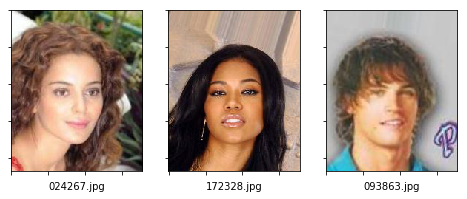

In [12]:
fig = plt.figure(figsize = (8,8))

for i in range(0, len(ran)):
    ax = fig.add_subplot(1,3, i+1)
    number="%06d.jpg" % ran[i]
    img = imread('./img_align_celeba/' + number)
    ax.set_xlabel(number )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(img)
    
plt.show()

**C. Create + compile Convolutional Variational Autoencoder Model (with encoder and decoder) with this face data.**

**D. Train on these images.**

In [ ]:
import os
import sys
import math
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib
matplotlib.use('Agg')

# vae in folder in which files are located
from vae.models import VAE, DCGAN
from vae.datasets import load_data


models = {
    'vae': VAE,
    'dcgan': DCGAN
}

def main():
    # Parsing arguments
    
    datasets = load_data('celebB.hdf5')

    # Construct model
    
#swap here for vae and dcgan
    model = models['vae'](
        input_shape=datasets.shape[1:],
        z_dims=256,
        output='output'
    )


    # Training loop
    datasets = datasets.images * 2.0 - 1.0
    print(len(datasets))
    samples = np.random.normal(size=(100, 256)).astype(np.float32)
    model.main_loop(datasets, samples,
        epochs=50,
        batchsize=50,
        reporter=['loss', 'g_loss', 'd_loss', 'g_acc', 'd_acc'])

main()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 256), (None, 268981760   input_3[0][0]                    
__________________________________________________________________________________________________
sample_normal_1 (SampleNormal)  [(None, 256), (None, 0           model_1[1][0]                    
                                                                 model_1[1][1]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 64, 64, 3)    6945667     sample_normal_1[0][0]            
__________

In [0]:
!ls output/vae/results/


**Show the output**

In [0]:
%matplotlib inline
img = imread('./output/vae/results/epoch_0200_batch_1000.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)

**H. Create + compile DCGAN model with same data.  Then print summaries for 1. discriminator model 2. generator model**

**I. Train model on same celeb dataset.**

**J. Generate + visualise 15 celeb faces.**

In [0]:
import os
import sys
import math
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib
matplotlib.use('Agg')

# vae in folder in which files are located
from vae.models import VAE, DCGAN
from vae.datasets import load_data


models = {
    'vae': VAE,
    'dcgan': DCGAN
}

def main():
    # Parsing arguments
    
    datasets = load_data('celebB.hdf5')

    # Construct model
    
#swap here for vae and dcgan
    model = models['dcgan'](
        input_shape=datasets.shape[1:],
        z_dims=256,
        output='output'
    )


    # Training loop
    datasets = datasets.images * 2.0 - 1.0
    print(len(datasets))
    samples = np.random.normal(size=(100, 256)).astype(np.float32)
    model.main_loop(datasets, samples,
        epochs=200,
        batchsize=50,
        reporter=['loss', 'g_loss', 'd_loss', 'g_acc', 'd_acc'])

main()

In [0]:
# change file name in the results

%matplotlib inline
img = imread('./output/dcgan/results/epoch_0200_batch_1000.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)

# **2. A. Download the anime face dataset ZIP; use a Keras Custom Data Generator. **


In [0]:
!wget https://www.dropbox.com/s/if2mkn5928sx46q/anime-faces.zip?dl=0

In [0]:
!mv anime-faces.zip?dl=0 anime.zip

In [0]:
!unzip anime.zip





E. Create + compile VAE-GAN Model with same data.  Print summaries for 1. encoder 2. decoder 3. discriminator model

F. Train model on dataset.

G. Generate + visualise 15 celebrity faces not in training set.

**FOR VAE**

In [0]:
import os
import sys
import math
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib
matplotlib.use('Agg')

# vae in folder in which files are located
from vae.models import VAE, DCGAN
from vae.datasets import load_data


models = {
    'vae': VAE,
    'dcgan': DCGAN
}

def main():
    # Parsing arguments
    
    datasets = load_data('anime.hdf5')

    # Construct model
    
#swap here for vae and dcgan
    model = models['vae'](
        input_shape=datasets.shape[1:],
        z_dims=256,
        output='output'
    )


    # Training loop
    datasets = datasets.images * 2.0 - 1.0
    print(len(datasets))
    samples = np.random.normal(size=(100, 256)).astype(np.float32)
    model.main_loop(datasets, samples,
        epochs=200,
        batchsize=50,
        reporter=['loss', 'g_loss', 'd_loss', 'g_acc', 'd_acc'])

main()

**SHOW OUTPUT**

In [0]:
# change file name in the results

%matplotlib inline
img = imread('./output/vae/results/epoch_0200_batch_1000.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)

B. Create + compile DCGAN model with same data.  Then print summaries for 1. discriminator model 2. generator model

C. Train model on dataset.

D. Generate + visualise 15 celebrity faces not in training set.

**FOR DCGAN**

In [0]:
import os
import sys
import math
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib
matplotlib.use('Agg')

# vae in folder in which files are located
from vae.models import VAE, DCGAN
from vae.datasets import load_data


models = {
    'vae': VAE,
    'dcgan': DCGAN
}

def main():
    # Parsing arguments
    
    datasets = load_data('anime.hdf5')

    # Construct model
    
#swap here for vae and dcgan
    model = models['dcgan'](
        input_shape=datasets.shape[1:],
        z_dims=256,
        output='output'
    )


    # Training loop
    datasets = datasets.images * 2.0 - 1.0
    print(len(datasets))
    samples = np.random.normal(size=(100, 256)).astype(np.float32)
    model.main_loop(datasets, samples,
        epochs=200,
        batchsize=50,
        reporter=['loss', 'g_loss', 'd_loss', 'g_acc', 'd_acc'])

main()

**FOR DCGAN OUTPUT**

In [0]:
# change file name in the results

%matplotlib inline
img = imread('./output/dcgan/results/epoch_0200_batch_1000.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)